# Exploring the coral data

In [2]:
import geopandas as gpd
# gml_file_coral_reefs = "./KystOgFiskeri_50_Trondelag_25832_Korallrev_GML.gml"
gml_file_coral_reefs = "./raw_data/KystOgFiskeri_50_Trondelag_25833_Korallrev_GML.gml"

coral_data = gpd.read_file(gml_file_coral_reefs)

print(coral_data.columns)

Index(['gml_id', 'lokalId', 'navnerom', 'verifiseringsdato', 'produkt',
       'versjon', 'målemetode', 'nøyaktighet', 'medium', 'opphav',
       'minimumsdybde', 'maksimumsdybde', 'naturtype', 'naturtypeNavn',
       'kildeNavn', 'observasjonsMetode', 'observasjonsSted',
       'observasjonsSlutt', 'lengdegrad', 'breddegrad', 'geometry'],
      dtype='object')


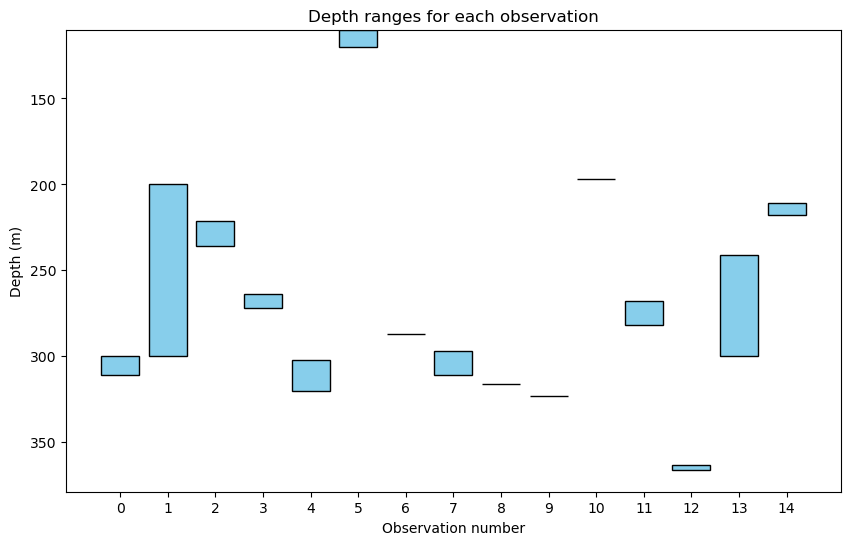

Number of coral data entries without depth data: 89 out of 104


In [3]:
import matplotlib.pyplot as plt
import numpy as np

coral_data_drop_depth_data = coral_data[(coral_data['minimumsdybde'] != 0) & (coral_data['maksimumsdybde'] != 0)]

observation_numbers = np.arange(0, len(coral_data_drop_depth_data))
min_depths = coral_data_drop_depth_data['minimumsdybde'].values  
max_depths = coral_data_drop_depth_data['maksimumsdybde'].values 
depth_ranges = max_depths - min_depths

plt.figure(figsize=(10, 6))
plt.bar(observation_numbers, depth_ranges, bottom=min_depths, color='skyblue', edgecolor='black')

plt.xlabel("Observation number")
plt.ylabel("Depth (m)")
plt.title("Depth ranges for each observation")
plt.xticks(observation_numbers)
plt.gca().invert_yaxis()  
plt.show()

missing_depth_data_count = coral_data[(coral_data['minimumsdybde'] == 0) | (coral_data['maksimumsdybde'] == 0)].shape[0]
print(f"Number of coral data entries without depth data: {missing_depth_data_count} out of {len(coral_data)}")

# Exploring SINMOD data

- PCA

# Exploring SINMOD and Coral data

- Histograms of features at coral data locations (and randomly sampled histograms)
- PLS


In [4]:
from netCDF4 import Dataset

# Importing SINMOD data
filename_PhysStates = '/cluster/projects/itk-SINMOD/coral-mapping/gin/spinup/run2/PhysStates.nc'

PhysStates_data = Dataset(filename_PhysStates, 'r')

# Looking at our list of available variables
variables_list = list(PhysStates_data.variables.keys())
for variable in variables_list:
    units = PhysStates_data.variables[variable].units if 'units' in PhysStates_data.variables[variable].ncattrs() else 'No units'
    print(f"{variable:<20} {units}")

# Import coral data
coral_data = gpd.read_file('./processed_data/coral_data_trondelag_processed.parquet')

time                 No units
grid_mapping         No units
LayerDepths          m
xc                   meter
yc                   meter
zc                   m
depth                m
DXxDYy               m2
u_velocity           m/s
v_velocity           m/s
elevation            m
temperature          degC
salinity             psu
ice_thickness        m
ice_compactness      -
salinity_ice         psu


In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Extracting temperature
temperature_var = PhysStates_data.variables['temperature']
zc = PhysStates_data.variables['LayerDepths'][:]
cumulative_depth = np.cumsum(zc, axis=0)
depth = PhysStates_data.variables['depth'][:]

# Using the first 150 time steps and all x, y coordinates
temperature = temperature_var[:150, :, :, :]
print(f"Temperature shape: {temperature.shape}")

# Check alignment of coral_x and coral_y with temperature matrix
valid_coordinates = []
coral_temperatures = []

for x, y in zip(coral_data['x'], coral_data['y']):
    # Ensure the coordinates are within the grid bounds
    if 0 <= x < temperature.shape[3] and 0 <= y < temperature.shape[2]:
        depth_at_point = depth[int(y), int(x)]
        layer_index = np.searchsorted(cumulative_depth, depth_at_point)
        temp_value = temperature[:, layer_index, int(y), int(x)]
        if not np.ma.is_masked(temp_value):
            valid_coordinates.append((int(x), int(y)))
            coral_temperatures.append(temp_value)

# Convert list to numpy array for easier manipulation
coral_temperatures = np.array(coral_temperatures)

# Print the number of valid coordinates
print(f"Number of valid coordinates: {len(valid_coordinates)}")
print(f"Total number of coral coordinates: {len(coral_data['x'])}")

# Print some valid coordinates for verification
print("Some valid coordinates (x, y):", valid_coordinates[:10])
# Print depths at valid coordinates
depths_at_valid_coords = [depth[int(y), int(x)] for x, y in valid_coordinates]
# Print depths at valid coordinates as integers
depths_at_valid_coords_int = [int(d) for d in depths_at_valid_coords]
print("Depths at valid coordinates (as int):", depths_at_valid_coords_int)

Temperature shape: (150, 25, 235, 300)
Number of valid coordinates: 63
Total number of coral coordinates: 104
Some valid coordinates (x, y): [(95, 39), (88, 39), (93, 38), (91, 39), (97, 38), (91, 37), (92, 39), (90, 39), (89, 39), (89, 39)]
Depths at valid coordinates (as int): [289, 275, 294, 274, 175, 243, 238, 310, 310, 310, 263, 67, 116, 116, 238, 310, 238, 238, 310, 294, 288, 238, 294, 265, 275, 67, 163, 289, 275, 250, 238, 310, 275, 310, 116, 265, 275, 116, 278, 243, 128, 289, 263, 116, 310, 310, 263, 116, 289, 274, 310, 274, 116, 116, 122, 122, 263, 275, 238, 274, 238, 310, 122]


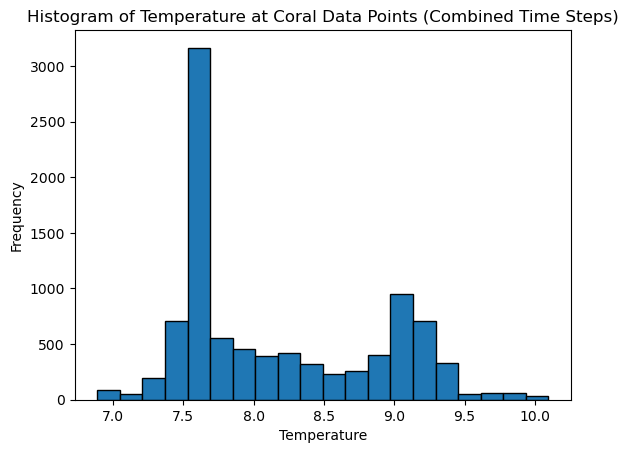

In [12]:
# Now plot histogram of temperature values at coral data points

def plot_histogram_at_coral_points(coral_data, variable_name, t_start, t_stop, netcdf_data):

    zc = netcdf_data.variables['LayerDepths'][:]
    cumulative_depth = np.cumsum(zc, axis=0)

    xc_shape = PhysStates_data.variables['xc'].shape[0]
    yc_shape = PhysStates_data.variables['yc'].shape[0]

    # Extract variable values at coral data points
    coral_values = []

    for time in range(t_start, t_stop):
        for x, y in zip(coral_data['x'], coral_data['y']):
            
            # Ensure the coordinates are within the grid bounds
            if 0 <= x < xc_shape and 0 <= y < yc_shape:

                depth_at_point = netcdf_data.variables['depth'][int(y), int(x)]
                layer_index = np.searchsorted(cumulative_depth, depth_at_point)
                value = netcdf_data.variables[variable_name][time, layer_index, int(y), int(x)]

                if not np.ma.is_masked(value):
                    coral_values.append(value)

    # Convert list to numpy array for easier manipulation
    coral_values = np.array(coral_values)

    # Flatten the array to combine all time steps
    coral_values_flat = coral_values.flatten()

    # Plot histogram of the combined variable values
    plt.hist(coral_values_flat, bins=20, edgecolor='black')
    plt.xlabel(f'{variable_name.capitalize()}')
    plt.ylabel('Frequency')
    plt.title(f'Histogram of {variable_name.capitalize()} at Coral Data Points (Combined Time Steps)')
    plt.show()

# Example usage
plot_histogram_at_coral_points(coral_data, 'temperature', 0, 150, PhysStates_data)

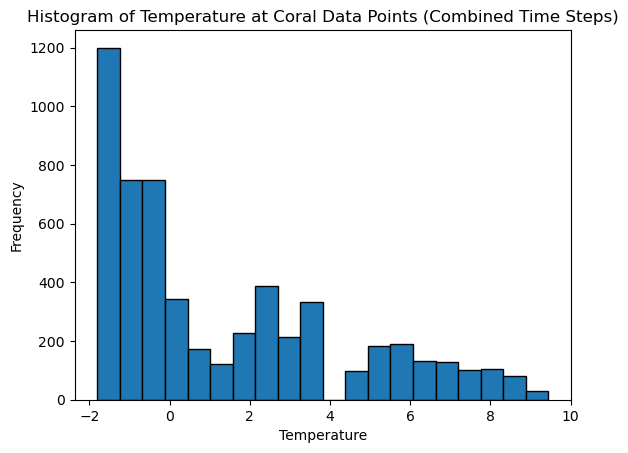

In [ ]:
import random

no_points = len(valid_coordinates)

# Generate 63 random x and y locations within the PhysStates grid
random_x = [random.randint(0, PhysStates_data.variables['xc'].shape[0] - 1) for _ in range(no_points)]
random_y = [random.randint(0, PhysStates_data.variables['yc'].shape[0] - 1) for _ in range(no_points)]

# Create a GeoDataFrame for the random points
random_points = gpd.GeoDataFrame({'x': random_x, 'y': random_y})

# Plot histogram of temperature values at random points
plot_histogram_at_coral_points(random_points, 'temperature', 0, 150, PhysStates_data)

/tmp/ipykernel_4112417/2278836657.py:10: RuntimeWarning: invalid value encountered in sqrt
  current_speed = np.sqrt(u_velocity**2 + v_velocity**2)


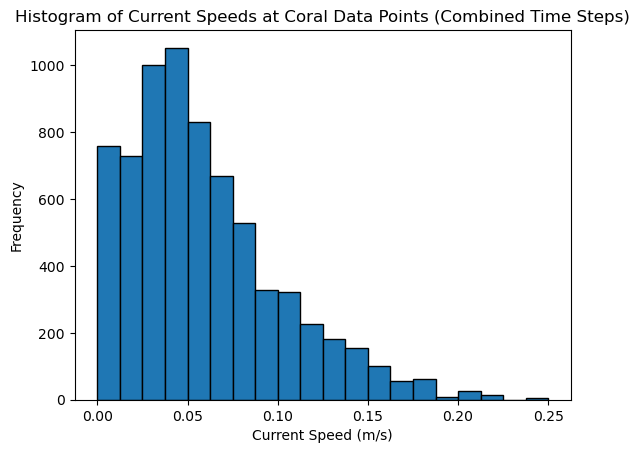

In [ ]:
# Extracting u and v velocity components at t = 0 and depth closest to 250m
u_velocity_var = PhysStates_data.variables['u_velocity']
v_velocity_var = PhysStates_data.variables['v_velocity']

# Using the first 150 time steps
u_velocity = u_velocity_var[:150, layer_index, :, :]
v_velocity = v_velocity_var[:150, layer_index, :, :]

# Calculate the magnitude of the current speed
current_speed = np.sqrt(u_velocity**2 + v_velocity**2)

# Extract current speed at coral data points
coral_current_speeds = []
for time in range(current_speed.shape[0]):
    for x, y in zip(coral_data['x'], coral_data['y']):
        # Ensure the coordinates are within the grid bounds
        if 0 <= x < current_speed.shape[2] and 0 <= y < current_speed.shape[1]:
            speed_value = current_speed[time, int(y), int(x)]
            if not np.ma.is_masked(speed_value):
                coral_current_speeds.append(speed_value)

# Convert list to numpy array for easier manipulation
coral_current_speeds = np.array(coral_current_speeds)

# Flatten the array to combine all time steps
coral_current_speeds_flat = coral_current_speeds.flatten()

# Plot histogram of the combined current speed values
plt.hist(coral_current_speeds_flat, bins=20, edgecolor='black')
plt.xlabel('Current Speed (m/s)')
plt.ylabel('Frequency')
plt.title('Histogram of Current Speeds at Coral Data Points (Combined Time Steps)')
plt.show()

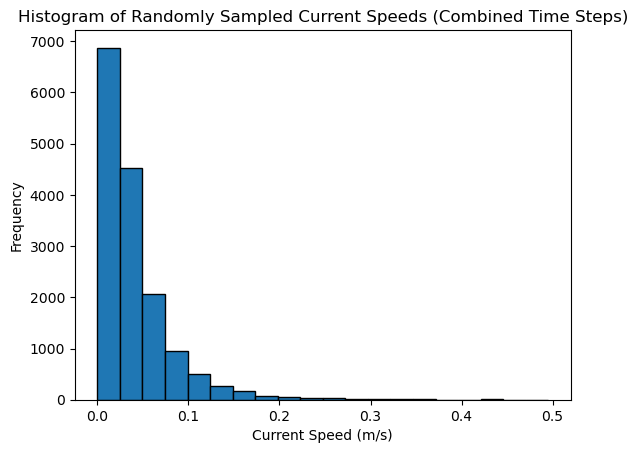

Total data points in coral current speeds histogram: 15600
Total data points in random current speeds histogram: 15600


In [ ]:
# Randomly sample the same number of points as the coral data at each time point
random_current_speeds = []

# Get the valid (non-masked) indices
valid_indices = np.argwhere(~current_speed.mask[0, :, :])

for time in range(current_speed.shape[0]):
    # Randomly select indices from the valid indices
    selected_indices = valid_indices[np.random.choice(valid_indices.shape[0], num_coral_points, replace=False)]
    
    for y_idx, x_idx in selected_indices:
        speed_value = current_speed[time, y_idx, x_idx]
        random_current_speeds.append(speed_value)

# Convert list to numpy array for easier manipulation
random_current_speeds = np.array(random_current_speeds)

# Flatten the array to combine all time steps
random_current_speeds_flat = random_current_speeds.flatten()

# Plot histogram of the combined random current speed values
plt.hist(random_current_speeds_flat, bins=20, edgecolor='black')
plt.xlabel('Current Speed (m/s)')
plt.ylabel('Frequency')
plt.title('Histogram of Randomly Sampled Current Speeds (Combined Time Steps)')
plt.show()

# Print the total number of data points on each histogram
print(f"Total data points in coral current speeds histogram: {len(coral_current_speeds_flat)}")
print(f"Total data points in random current speeds histogram: {len(random_current_speeds_flat)}")